In [2]:
#import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import os

## Commits and contributors

### Data Cleaning & Processing

In [3]:
#read raw.txt file
rawCommit = pd.read_json("Raw/Commit/raw.txt") 
type(rawCommit)

pandas.core.frame.DataFrame

In [22]:
#split the data in 'commit' column
formatedCommit = pd.json_normalize(rawCommit.commit)
#clear useless data
formatedCommit = formatedCommit.filter(['author.name', 'committer.date'])
#format committer date into date format
formatedCommit['committer.date'] = pd.to_datetime(formatedCommit['committer.date'].str.slice(0, 10))
#sort by date
formatedCommit = formatedCommit.sort_values(by = 'committer.date')
#export to csv file
formatedCommit.to_csv('Data/Commit/clearedFile.csv', index = False)
#print the result
formatedCommit.set_index('author.name', inplace = True)

0        {'author': {'name': 'Zack Tanner', 'email': '1...
1        {'author': {'name': 'vercel-release-bot', 'ema...
2        {'author': {'name': 'JJ Kasper', 'email': 'jj@...
3        {'author': {'name': 'vercel-release-bot', 'ema...
4        {'author': {'name': 'Zack Tanner', 'email': '1...
                               ...                        
21214    {'author': {'name': 'nkzawa', 'email': 'naoyuk...
21215    {'author': {'name': 'Guillermo Rauch', 'email'...
21216    {'author': {'name': 'nkzawa', 'email': 'naoyuk...
21217    {'author': {'name': 'Guillermo Rauch', 'email'...
21218    {'author': {'name': 'Guillermo Rauch', 'email'...
Name: commit, Length: 21219, dtype: object


### Commits

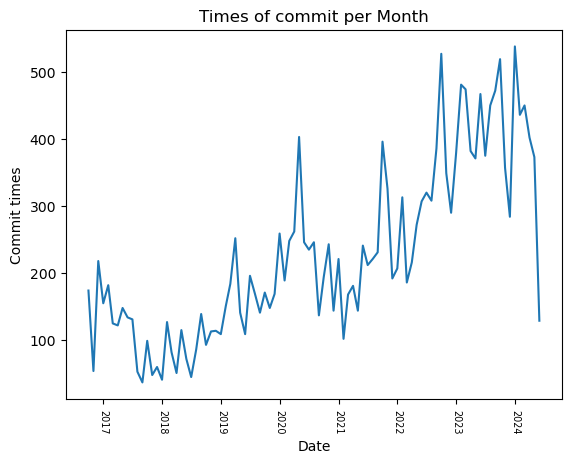

In [5]:
#Times of commit per day
date = formatedCommit.copy()
date['committer.month'] = date['committer.date'].apply(lambda x: x.strftime('%Y-%m')) 
date
date = date['committer.month'].groupby(pd.to_datetime(date['committer.month'])).count()
plt.plot(date.index, date.values)
plt.xlabel('Date')
plt.ylabel('Commit times')
plt.title('Times of commit per Month')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=270, fontweight='light',  fontsize='x-small')
plt.show()

### Contributors

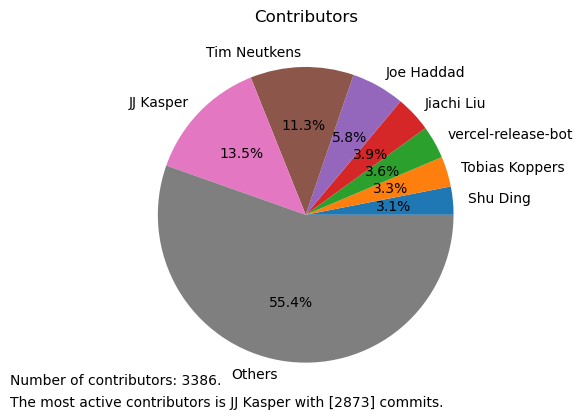

In [6]:
#Contributor
contri = formatedCommit.pivot_table(index = 'author.name', values = 'committer.date', aggfunc = 'count')
contri = contri.sort_values(by='committer.date')
contri
contri2 = contri[-7:].copy()
contri2.loc['Others'] = contri[:-7].sum()
plt.text(-2, -1.15, f'Number of contributors: {len(contri)}.')
plt.text(-2, -1.3, f'The most active contributors is {contri.index[-1]} with {contri.values[-1]} commits.')
plt.pie(contri2['committer.date'], labels=contri2.index, autopct='%1.1f%%')
plt.title('Contributors')
plt.show()

Brandon Bayer


/tmp/ipykernel_4987/73573820.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if top20Contri['time'][i] == top20Contri['time'][-1]:
/tmp/ipykernel_4987/73573820.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(-3, -950, f'Longest contributor time: {mostContriString} with {top20Contri["time"][-1]} days.')


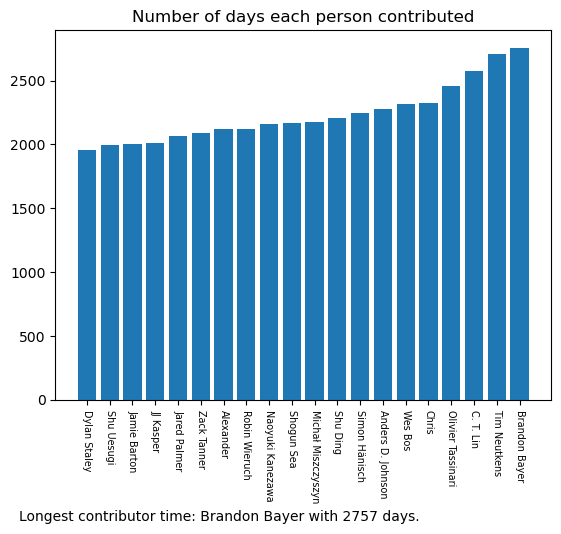

In [7]:
contriTime = formatedCommit.sort_values(by = ['author.name', 'committer.date'], ascending = [True, True])[[ 'committer.date']]
firstContri = contriTime[~contriTime.index.duplicated(keep='first')]
lastContri = contriTime[~contriTime.index.duplicated(keep='last')]
contriTime = pd.merge(firstContri, lastContri, right_index=True, left_index=True, suffixes=('_first', '_last'))
contriTime['time'] = (contriTime['committer.date_last'] - contriTime['committer.date_first']).dt.days +1
contriTime = contriTime.sort_values(by = 'time')
top20Contri = contriTime[-20:].copy()
plt.subplot().bar(x = top20Contri.index, height = top20Contri['time'])
plt.xticks(rotation=270, fontweight='light',  fontsize='x-small')
plt.title("Number of days each person contributed")
mostContriString = ""
for i in range (0, len(top20Contri) - 1) :
    if top20Contri['time'][i] == top20Contri['time'][-1]:
        mostContriString += top20Contri.index[i] + ", "
mostContriString += top20Contri.index[-1]
print (mostContriString)
plt.text(-3, -950, f'Longest contributor time: {mostContriString} with {top20Contri["time"][-1]} days.')
plt.show()

/tmp/ipykernel_4987/2049783655.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  freq30daysmore = freq[contriTime['time'] > 2000]
/tmp/ipykernel_4987/2049783655.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(-5, -0.5, f'Most frequency contributor: {freq30daysmore.index[-1]} with {freq30daysmore["freq"][-1]:.2f} commits/day.')


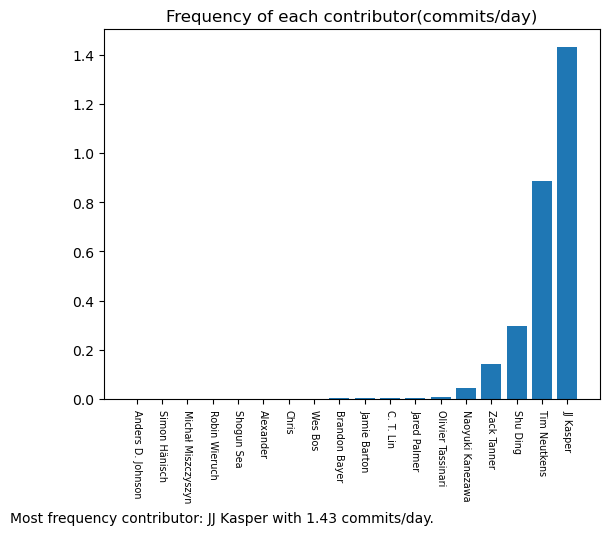

In [8]:
freq = pd.merge(contri, contriTime, on='author.name', suffixes=('_contr', '_time'))
freq["freq"] = freq["committer.date"] / freq["time"]
freq.to_csv('Data/Commit/finalFile.csv', index = False)
freq30daysmore = freq[contriTime['time'] > 2000]
freq30daysmore = freq30daysmore.sort_values(by = 'freq')
plt.subplot().bar(x = freq30daysmore.index, height = freq30daysmore['freq'])
plt.xticks(rotation=270, fontweight='light',  fontsize='x-small')
plt.title("Frequency of each contributor(commits/day)")
plt.text(-5, -0.5, f'Most frequency contributor: {freq30daysmore.index[-1]} with {freq30daysmore["freq"][-1]:.2f} commits/day.')
plt.show()

## Issues

### Data Cleaning & Processing

In [24]:
#read raw.txt file
rawIssue = pd.read_json("Raw/Issue/raw.txt") 
formatedIssue = rawIssue[['title', 'created_at', 'closed_at']]
formatedIssue['created_at'] = pd.to_datetime(formatedIssue['created_at'].astype(str).str.slice(0, 10))
formatedIssue['closed_at'] = pd.to_datetime(formatedIssue['closed_at'].astype(str).str.slice(0, 10))
formatedIssue.set_index('title', inplace = True)
formatedIssue = formatedIssue.sort_values(by = 'created_at')
formatedIssue.to_csv('Data/Issue/clearedFile.csv', index = False)

                                                title  \
0      tweak deploy test concurrency & fail condition   
1                 Revert "chore: bump turbo to 2.0.3"   
2                   fix app-custom-routes deploy test   
3                       fix client-cache deploy tests   
4         tweak deploy failure notification condition   
...                                               ...   
39369           Set test command and added more tests   
39370                                Add/render tests   
39371        Fixes next dev and adds the css requires   
39372                        Exposing css as next/css   
39373                       Added css using aphrodite   

                     created_at                 closed_at  
0     2024-06-12 02:38:14+00:00 2024-06-12 02:38:33+00:00  
1     2024-06-12 01:13:24+00:00 2024-06-12 01:17:06+00:00  
2     2024-06-11 22:12:14+00:00 2024-06-11 22:41:37+00:00  
3     2024-06-11 21:50:10+00:00 2024-06-11 22:17:44+00:00  
4     2024-06-1

/tmp/ipykernel_4987/4030999669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formatedIssue['created_at'] = pd.to_datetime(formatedIssue['created_at'].astype(str).str.slice(0, 10))
/tmp/ipykernel_4987/4030999669.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  formatedIssue['closed_at'] = pd.to_datetime(formatedIssue['closed_at'].astype(str).str.slice(0, 10))


### Issues

/tmp/ipykernel_4987/3047806718.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timeSolve['timeSolve'][0] = formatedIssue[formatedIssue['timeSolve'] == 0]['timeSolve'].count()
/tmp/ipykernel_4987/3047806718.py:5: FutureWarning: Series.__s

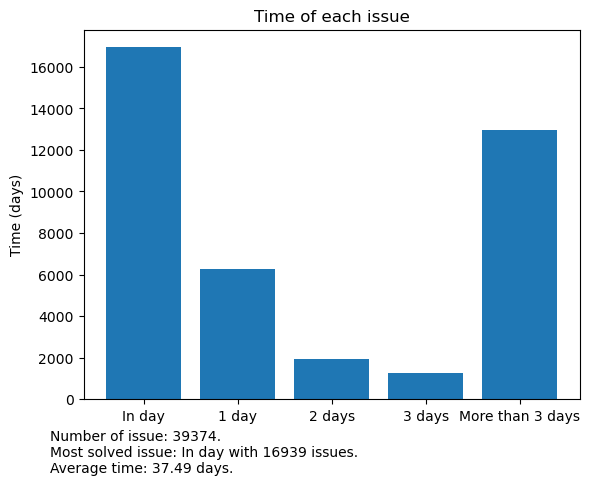

In [10]:
formatedIssue['timeSolve'] = (formatedIssue['closed_at'] - formatedIssue['created_at']).dt.days
timeSolve = pd.DataFrame()
timeSolve.index = ['In day', '1 day', '2 days', '3 days', 'More than 3 days']
timeSolve['timeSolve'] = [formatedIssue[formatedIssue['timeSolve'] == 0].count(), 0, 0, 0, 0]
timeSolve['timeSolve'][0] = formatedIssue[formatedIssue['timeSolve'] == 0]['timeSolve'].count() 
timeSolve['timeSolve'][1] = formatedIssue[formatedIssue['timeSolve'] == 1]['timeSolve'].count()
timeSolve['timeSolve'][2] = formatedIssue[formatedIssue['timeSolve'] == 2]['timeSolve'].count()
timeSolve['timeSolve'][3] = formatedIssue[formatedIssue['timeSolve'] == 3]['timeSolve'].count()
timeSolve['timeSolve'][4] = formatedIssue[formatedIssue['timeSolve'] > 3]['timeSolve'].count()
plt.subplot().bar(x = timeSolve.index, height = timeSolve['timeSolve'])
plt.ylabel('Time (days)')
plt.title('Time of each issue')
plt.text(-1, -2000, f'Number of issue: {len(formatedIssue)}.')
plt.text(-1, -2750, f'Most solved issue: {timeSolve["timeSolve"].idxmax()} with {timeSolve["timeSolve"].max()} issues.')
plt.text(-1, -3500, f'Average time: {formatedIssue["timeSolve"].mean():.2f} days.')
formatedIssue.to_csv('Data/Issue/finalFile.csv', index = False)

## Pull requests

### Data Cleaning & Processing

In [11]:
#combine all raw files into one

# os.makedirs("Data", exist_ok=True)
# read_files = glob.glob("Raw/Pull/*.txt")
# combined_content = ""

# for i, f in enumerate(read_files):
#     with open(f, "r") as infile:
#         content = infile.read()
#         if i > 0:
#             content = content.lstrip().lstrip('[')
#         if i < len(read_files) - 1:
#             content = content.rstrip().rstrip(']') + ','
#         combined_content += content
# if(os.path.exists("Data/Pull/") == False): os.mkdir("Data/Pull")
# with open("Data/Pull/rawFile.txt", "w") as outfile:
#     outfile.write(combined_content)

In [12]:
#read raw.txt file
rawPull = pd.read_json("Raw/Pull/raw.txt") 
# rawPull.to_csv('Data/Pull/clearedFile.csv', index = False)
formatedPull = rawPull.filter(['title', 'created_at', 'merged_at'])
formatedPull.set_index('title', inplace = True)
formatedPull.to_csv('Data/Pull/clearedFile.csv', index = False)



/tmp/ipykernel_4987/2530808307.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  totalPullRequest['merged'][0] = formatedPull[formatedPull['merged'] == True]['merged'].count()
/tmp/ipykernel_4987/2530808307.py:7: FutureWarning: Series.__se

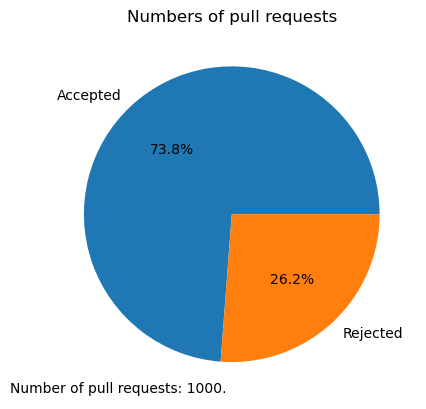

In [13]:
formatedPull.columns
formatedPull['merged'] = formatedPull['merged_at'].notna()
formatedPull
totalPullRequest = pd.DataFrame()
totalPullRequest.index = ['Accepted', 'Rejected']
totalPullRequest['merged'] = [0, 0]
totalPullRequest['merged'][0] = formatedPull[formatedPull['merged'] == True]['merged'].count()
totalPullRequest['merged'][1] = formatedPull[formatedPull['merged'] == False]['merged'].count()
plt.pie(totalPullRequest['merged'], labels=totalPullRequest.index, autopct='%1.1f%%')
plt.title("Numbers of pull requests")
plt.text(-1.5, -1.2, f'Number of pull requests: {len(formatedPull)}.')
plt.show()

/tmp/ipykernel_4987/4067612673.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timePull['time'][0] = acceptedPull[acceptedPull['time'] == 0]['time'].count()
/tmp/ipykernel_4987/4067612673.py:10: FutureWarning: Series.__setitem__ treatin

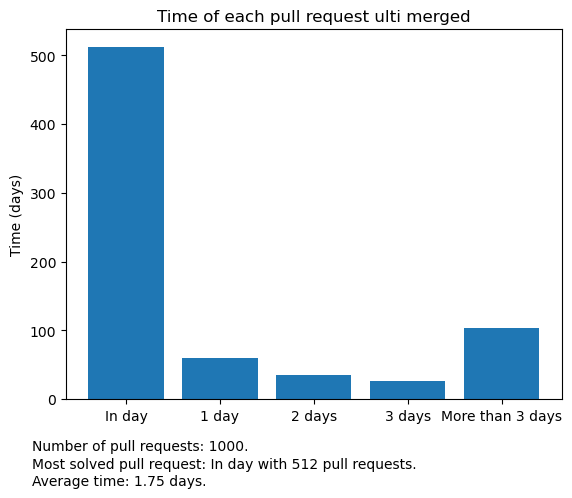

In [14]:

formatedPull['time'] = (formatedPull['merged_at'] - formatedPull['created_at']).dt.days
acceptedPull = formatedPull[formatedPull['merged'] == True]


acceptedPull

timePull = pd.DataFrame()
timePull.index = ['In day', '1 day', '2 days', '3 days', 'More than 3 days']
timePull['time'] = [0, 0, 0, 0, 0]
timePull['time'][0] = acceptedPull[acceptedPull['time'] == 0]['time'].count() 
timePull['time'][1] = acceptedPull[acceptedPull['time'] == 1]['time'].count()
timePull['time'][2] = acceptedPull[acceptedPull['time'] == 2]['time'].count()
timePull['time'][3] = acceptedPull[acceptedPull['time'] == 3]['time'].count()
timePull['time'][4] = acceptedPull[acceptedPull['time'] > 3]['time'].count()
plt.subplot().bar(x = timePull.index, height = timePull['time'])
plt.ylabel('Time (days)')
plt.title('Time of each pull request ulti merged')
plt.text(-1, -75, f'Number of pull requests: {len(formatedPull)}.')
plt.text(-1, -100, f'Most solved pull request: {timePull["time"].idxmax()} with {timePull["time"].max()} pull requests.')
plt.text(-1, -125, f'Average time: {acceptedPull["time"].mean():.2f} days.')
formatedPull.to_csv('Data/Pull/finalFile.csv', index = False)



## Languages

### Data Cleaning & Processing

In [15]:
#combine all raw files into one

os.makedirs("Data", exist_ok=True)
read_files = glob.glob("Raw/Languages/*.txt")
combined_content = ""

for i, f in enumerate(read_files):
    with open(f, "r") as infile:
        content = infile.read()
        if i > 0:
            content = content.lstrip().lstrip('[')
        if i < len(read_files) - 1:
            content = content.rstrip().rstrip(']') + ','
        combined_content += content
if(os.path.exists("Data/Languages/") == False): os.mkdir("Data/Languages")
with open("Data/Languages/rawFile.txt", "w") as outfile:
    outfile.write(combined_content)

### Languages

Text(-1.2, -1.2, 'JavaScript is most used in this repo, with 29790821 bytes of code.')

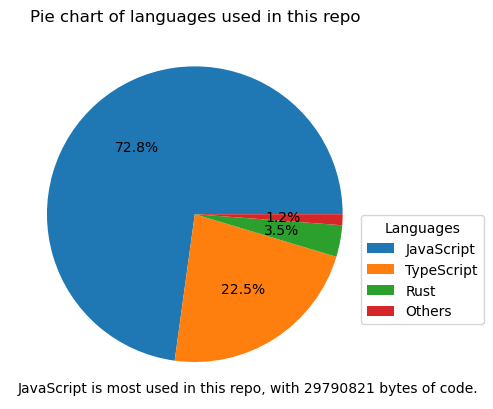

In [16]:

formatedLang = pd.read_json("Data/Languages/rawFile.txt",  typ='series')
formatedLang.to_csv("Data/Languages/finalFile.csv")
pieLang = formatedLang[:3]
pieLang['Others'] = formatedLang[3:].sum()
plt.pie(pieLang.values, autopct='%1.1f%%')
plt.subplot().legend(
    labels = pieLang.index,
    title='Languages',
    loc = 'center right',
    bbox_to_anchor = (1, 0, 0.3, 0.7)
)
plt.title("Pie chart of languages used in this repo")
plt.text(-1.2, -1.2, f'{formatedLang.idxmax()} is most used in this repo, with {formatedLang.max()} bytes of code.')


## Contents

### Data Cleaning & Processing

In [17]:
formatedCon = pd.read_json("Raw/Content/raw.txt")
formatedCon.to_csv('Data/Content/clearedFile.csv')


In [18]:
formatedCon = formatedCon.filter(['name', 'size'])
formatedCon.sort_values(by = 'size', ascending = False).head(10)
print("Largest file size is ", formatedCon['size'])

Largest file size is  0         45
1        315
2          0
3          0
4          0
5       1539
6      10889
7        569
8        191
9          0
10       576
11         0
12         4
13       133
14      1795
15        69
16       192
17         0
18      3298
19    214470
20      4317
21       252
22      6461
23         0
24      1462
25         0
26         0
27         0
28         0
29      1763
30       635
31       332
32      1079
33       306
34     10778
35         0
36         0
37    911833
38        85
39        23
40      3695
41     23161
42        98
43         0
44       298
45        33
46         0
47       146
48       814
49       972
50       415
51         0
52        73
Name: size, dtype: int64
